# Collating and cleaning fish data
This notebook collates and cleans the fish tracking data from [source](https://dx.doi.org/10.17617/3.4y).<br>
The dataset we are interested in are those files prepended with *reversals3m_1024_dotbot_20181025_105202*<br>
The data consists of the tracking observation data for approximately 1024 sunbleak fish in a 3m tank. Each fish has its observations contained in an individual .npz file, which we will combine. There are 40 frames per second for 500 seconds.

## Collating the fish data

In [1]:
"""
@author: Mark Bugden, Max Planck Institute for Animal Behavior. 
August 2022

Building on the work of https://maziarraissi.github.io/PINNs/
Most recent update available on github:
"""


# Import the usual stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# This gives us a progress bar for longer computations. 
from tqdm.notebook import tqdm
# To use it, just wrap any iterable with tqdm(iterable).
# Eg: 
# for i in tqdm(range(100)):
#     ....

from scipy import stats


# Specify the folder location for the data
data_folder_location = "D:\\Data\\TRex data\\results_accurate_no_posture_data\\media\\recordings\\tristan\\paper\\2.Jun.20\\accurate_no_posture\\data\\reversals3m_1024_dotbot_20181025_105202\\"

### Warning: the following code takes about 1min20s to compute this cell. Concatenating dataframes is inefficient (it's better to concatenate lists and then convert to DataFrame at end).
 I will try to improve this when I get a chance, but for now it works. 

In [2]:
# This loads the individual files and stores them as a dataframe, then appends that dataframe to the previous dataframes
# The quantities we are interested in are the x and y positions, the time, the frame, and the fish number

# We will build the dataframe one fish at a time, but instead of initialising an empty dataframe we will start with the first fish, Fish 0

with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+'0'+'.npz') as fish_data:
    npz = fish_data
    Fish = list(np.full(npz['time'].shape, 0, dtype=int))
    x = list(npz['X#wcentroid'])
    y = list(npz['Y#wcentroid'])
    t = list(npz['time'])
    frame = list(npz['frame'])
    frame = [int(f) for f in frame]
    fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
    df = pd.DataFrame(fish_dict)

# We now iterate through the rest of the fish, creating and appending a dataframe for each fish to df.



for i in tqdm(range(1,1126)):

    with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+str(i)+'.npz') as fish_data:
        npz = fish_data
        Fish = list(np.full(npz['time'].shape, i, dtype=int))
        x = list(npz['X#wcentroid'])
        y = list(npz['Y#wcentroid'])
        t = list(npz['time'])
        frame = list(npz['frame'])
        frame = [int(f) for f in frame]
        fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
        df = pd.concat([df, pd.DataFrame(fish_dict)])



df = df.sort_values(['Fish','frame'])
df = df.set_index(['Fish'])
df

  0%|          | 0/1125 [00:00<?, ?it/s]

,t,x,y,frame
Fish,,,,
0,0.224779,72.011169,119.371750,8
0,0.249735,inf,inf,9
0,0.274696,72.386383,119.354118,10
0,0.299712,72.611839,119.335945,11
0,0.324633,72.851936,119.275497,12
...,...,...,...,...
1125,499.824249,74.614189,117.827614,20009
1125,499.849274,74.443268,117.816742,20010
1125,499.874268,74.245605,117.802887,20011


## Cleaning the fish data

In [3]:
# Now that we have all of our data in a big dataframe, we can check to see if it is clean
# Let's start by looking at the datatypes of the columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22533844 entries, 0 to 1125
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   t       float32
 1   x       float32
 2   y       float32
 3   frame   int64  
dtypes: float32(3), int64(1)
memory usage: 601.7 MB
None


In [4]:
# This looks good. let's check out the max and min values

print('mins are: \n', df.min(), '\n')
print('maxs are: \n', df.max())

mins are: 
 t        0.000000
x        2.974756
y        3.064423
frame    0.000000
dtype: float64 

maxs are: 
 t        4.999242e+02
x                 inf
y                 inf
frame    2.001300e+04
dtype: float64


In [5]:
# Ok, this is a problem. The mins are fine, but the max contains "inf" in the x and y columns. This happens when TRex can't distinguish between two fish.
# We need to clean this up by replacing inf with an appropriate number.


# It seems that whenever x is inf, then y is also inf. We should first check this is true. 
print('x is "inf" if and only if y is also "inf": ', (df['x']==float('inf')).equals(df['y']==float('inf')))

x is "inf" if and only if y is also "inf":  True


### Imputing missing values in x and y position
The easiest method would be to just replace all inf with NaN, then sort by fish and time and fill forward. This would mean that any "inf" values are replaced by the value that the fish last had. The problem with this is that if there are multiple "inf" entries in a row, it might make the fish look like it is standing still and then jumping forward. This would cause an artifact to appear in the speeds which would show a lot more fish having exactly zero velocity than you would expect. A more sophisticated method would be to linearly interpolate the position of the fish between the value it had before the "inf" entries, and the value it had after. Let's do the second one.

In [6]:
# Here we implement the more sophisticated method for imputing the missing x and y values, namely we linearly interpolate the x and y position between missing values

# First replace all the "inf" with NaN
df.loc[df['x'] == float('inf'), 'x'] = np.nan
df.loc[df['y'] == float('inf'), 'y'] = np.nan

df = df.interpolate()

# Verify that we've removed the inf and the max is more sensible.  
print('number of "inf" in the x column: ', df['x'].isna().sum())
print('number of "inf" in the y column: ', df['y'].isna().sum())
print('number of "inf" in the t column: ', df['t'].isna().sum())
print('maxs are: \n', df.max())

number of "inf" in the x column:  0
number of "inf" in the y column:  0
number of "inf" in the t column:  0
maxs are: 
 t          499.924164
x          119.099846
y          122.004288
frame    20013.000000
dtype: float64


## Extracting velocities
We now turn our attention to extracting the velocities of the fish. The simplest way to do this is to just use the difference in position between two consecutive frames. We must be careful, however, to ensure that when the tracking 'jumps', that we don't include the velocity associated to that jump. This may be difficult to do perfectly, but a rough estimate would be to simply discard any velocities which are higher than the maximum speed of a sunbleak.

In [7]:
# This cell extracts the velocities of the fish. 
# The velocity is the difference between the next frame and the current frame.

# Create a new column, 'vx', which is the difference between the x column shifted by 1 and the x column
df['vx'] = df['x'].shift(-1) - df['x']

# Do the same thing for y
df['vy'] = df['y'].shift(-1) - df['y']

# The last row for each fish will be invalid since the velocities will have been calculated as the difference between their position and the position of another fish.
# We will set it to NaN. 
df.loc[df.groupby(['Fish'])['frame'].transform(max) == df['frame'], 'vx'] = np.nan
df.loc[df.groupby(['Fish'])['frame'].transform(max) == df['frame'], 'vy'] = np.nan

# We actually want to remove those final rows from each fish, so we can simply dropna for the dataframe.
# If we want to keep them for some reason we can just comment out the following line.
df = df.dropna()

In [8]:
df

,t,x,y,frame,vx,vy
Fish,,,,,,
0,0.224779,72.011169,119.371750,8,0.187607,-0.008820
0,0.249735,72.198776,119.362930,9,0.187607,-0.008812
0,0.274696,72.386383,119.354118,10,0.225456,-0.018173
0,0.299712,72.611839,119.335945,11,0.240097,-0.060448
0,0.324633,72.851936,119.275497,12,0.185051,-0.079430
...,...,...,...,...,...,...
1125,499.799286,74.756088,117.845467,20008,-0.141899,-0.017853
1125,499.824249,74.614189,117.827614,20009,-0.170921,-0.010872
1125,499.849274,74.443268,117.816742,20010,-0.197662,-0.013855


In [9]:
# Let's take another look at our dataframe and see if the velocities we have make sense

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,t,x,y,frame,vx,vy
count,22532718.000,22532718.000,22532718.000,22532718.000,22532718.000,22532718.000
mean,249.938,58.273,62.214,10005.803,-0.000,-0.001
std,144.299,32.424,34.569,5776.764,0.379,0.383
min,0.000,2.975,3.064,0.000,-9.983,-11.529
25%,124.975,30.352,32.278,5003.000,-0.099,-0.107
50%,249.925,57.816,62.092,10006.000,-0.000,0.001
75%,374.949,85.611,92.075,15009.000,0.098,0.107
max,499.899,119.100,122.004,20012.000,10.922,14.046


### Replacing super large velocities with NaN
The mean velocity being very close to zero is reasonable, since the velocities point in all directions and the vector average would cancel out.
The max and min velocities, however, are cause for concern. We suspect that these are artifacts of the tracking 'jumping'.
That is, the tracking identifies a fish on one side of the tank in one frame, and then in the next frame thinks that fish is on the other side of the tank.

I think the best way to do this is to just apply a mask so if a velocity is above a given value, we set it to NaN.
After looking up [fish data](https://www.fishbase.in/summary/Leucaspius-delineatus.html) I have found that the average swimming speed for sunbleak is on the order of 0.58 m/s.
This is sustained swimming speeds, not burst speeds, but I think it's sensible to screen anything more than about 2 times this speed. This somewhat arbitrary value also happens to be approximately 3 times the standard deviation, so screening anything outside of that is a pretty reasonable thing to do. 



In [10]:
# The velocities we have in our data are not in m/s. The x and y ranges for the data are approximately (0,125) and (0, 125), but the tank is 3m x 3m. 
# The time between frames is also 0.025s. If we want to screen velocities above 1 m/s, this corresponds to a velocity (in our units) of:

max_vel = 1*(125/3)/(40)
max_vel

1.0416666666666665

In [11]:
# Ok, so it turns out it doesn't really matter if we use our units or m/s, since they end up being roughly the same. 

# Subsetting the values where either the x or y velocities are above max_vel:
df.loc[(df['vx'].abs() >= max_vel) | (df['vy'].abs() >= max_vel), 'vx'] = np.nan 
df.loc[(df['vx'].abs() >= max_vel) | (df['vy'].abs() >= max_vel), 'vy'] = np.nan 

# Once again we will drop these na values
df = df.dropna()

In [12]:
df.describe()

,t,x,y,frame,vx,vy
count,21741338.000,21741338.000,21741338.000,21741338.000,21741338.000,21741338.000
mean,248.638,58.328,62.211,9953.751,-0.001,-0.000
std,143.578,32.371,34.544,5747.919,0.187,0.196
min,0.000,2.975,3.064,0.000,-1.042,-1.042
25%,124.151,30.518,32.326,4970.000,-0.095,-0.103
50%,247.927,57.873,62.091,9926.000,-0.000,0.001
75%,372.027,85.586,92.019,14895.000,0.094,0.103
max,499.899,118.421,122.002,20012.000,1.042,1.042


In [13]:
# We see now that the x and y velocities are between -max_vel and max_vel, and the mean velocity didn't change substantially. It looks like we got a lot of the outliers. 

In [13]:
# Finally, we can add another column containing the instantaneous speed of the fish, given by sqrt(vx^2 + vy^2)

df['speed'] = (df['vx']**2 + df['vy']**2)**(1/2)

D:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df.describe()

,t,x,y,frame,vx,vy,speed
count,21741338.000,21741338.000,21741338.000,21741338.000,21741338.000,21741338.000,21741338.000
mean,248.638,58.328,62.211,9953.751,-0.001,-0.000,0.210
std,143.578,32.371,34.544,5747.919,0.187,0.196,0.170
min,0.000,2.975,3.064,0.000,-1.042,-1.042,0.000
25%,124.151,30.518,32.326,4970.000,-0.095,-0.103,0.116
50%,247.927,57.873,62.091,9926.000,-0.000,0.001,0.173
75%,372.027,85.586,92.019,14895.000,0.094,0.103,0.243
max,499.899,118.421,122.002,20012.000,1.042,1.042,1.466


## Simple data exploration

In [15]:
# The maximum and minimum ranges for the x and y values are:

print('x minimum is: ', df['x'].min())
print('x maximum is: ', df['x'].max())
print('y minimum is: ', df['y'].min())
print('y maximum is: ', df['y'].max())


# Given this, it seems a sensible range for plotting x and y is x in (0, 125), y in (0,125).
xmin = 0
xmax = 125
ymin = 0
ymax = 125

x minimum is:  2.9747562
x maximum is:  118.42089
y minimum is:  3.0644226
y maximum is:  122.00207


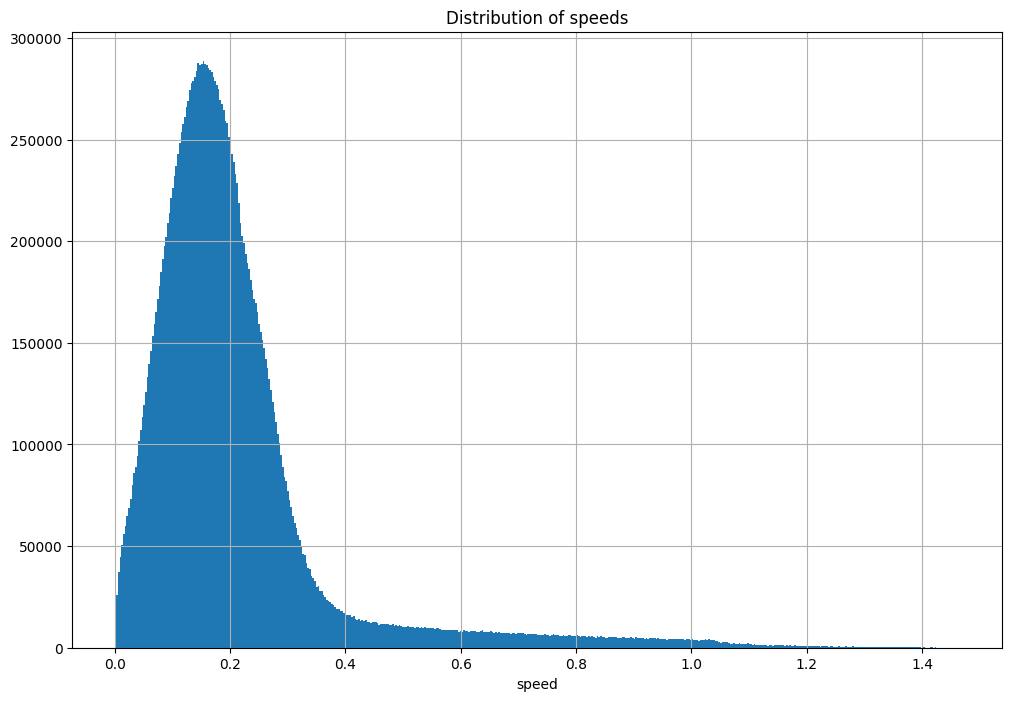

In [18]:
# We can look at the distribution of speeds

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('speed')

df.hist(ax = ax, column='speed', bins=500)
plt.title('Distribution of speeds')
plt.savefig('Distribution_of_speeds.png')
plt.show()


In [18]:
# Gorgeous!




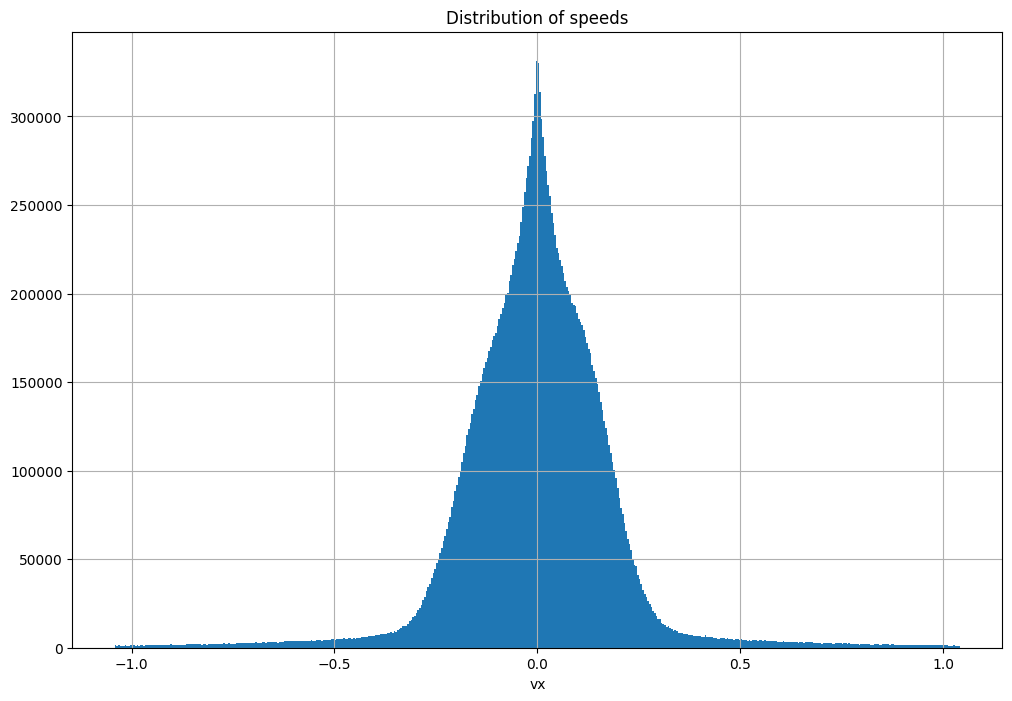

In [19]:
# We can also look at the distribution of vx and vy

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('vx')

df.hist(ax = ax, column='vx', bins=500)
plt.title('Distribution of speeds')
plt.show()

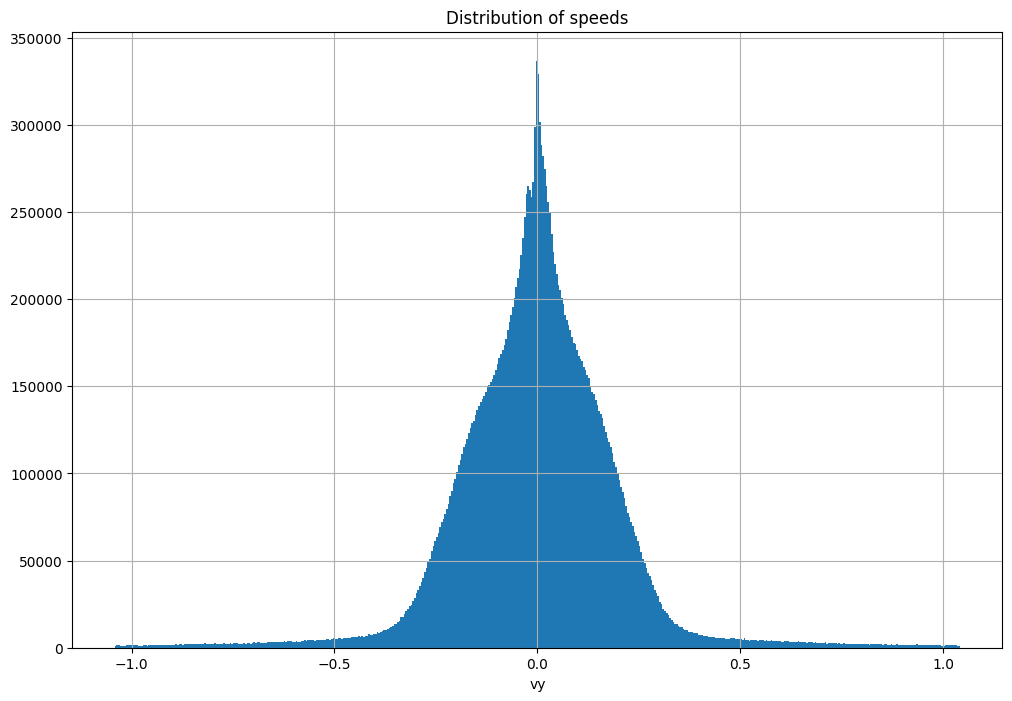

In [20]:
# We can also look at the distribution of vx and vy

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.set_xlabel('vy')

df.hist(ax = ax, column='vy', bins=500)
plt.title('Distribution of speeds')
plt.show()

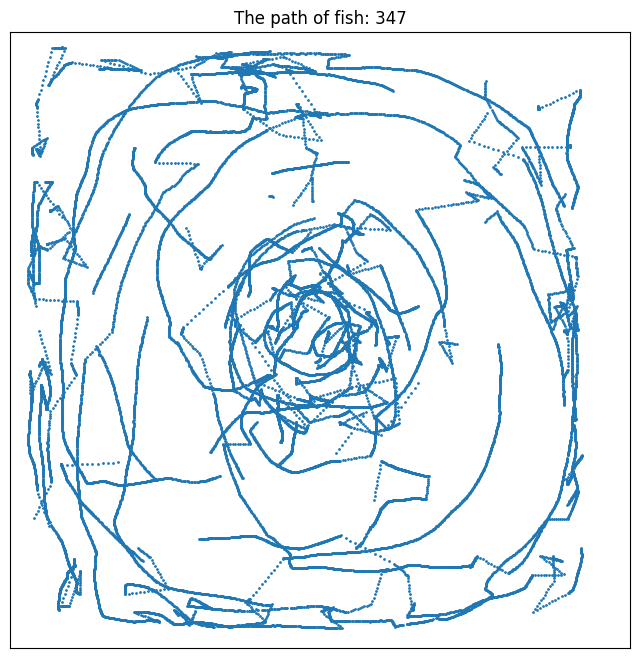

In [29]:
# Let's look at a random fish, and look at its (x,y) position over time
# First, pick a random fish 

testfish = 347

fig, ax = plt.subplots()

ax.scatter(df.loc[testfish,:]['x'], df.loc[testfish,:]['y'], s=1, c='tab:blue')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("The path of fish: " + str(testfish)))

fig.set_size_inches(8,8)
#plt.savefig('Fish347.png')
plt.show()

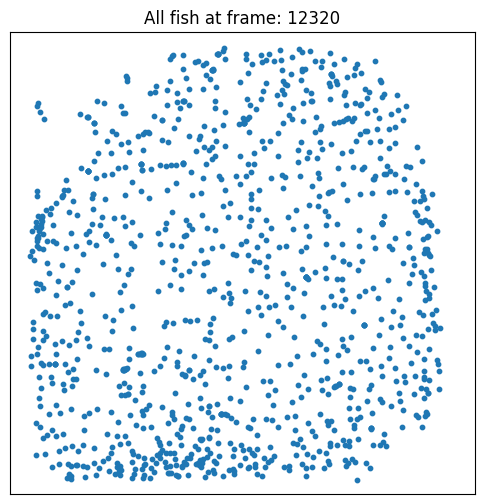

In [44]:
# Alternatively, we can look at all the fish at a given frame
# First, pick a random frame
testframe= 12320

fig, ax = plt.subplots()

# ax.scatter(df[df.index.get_level_values(1)==testframe]['x'], df[df.index.get_level_values(1)==testframe]['y'], s=10, c='tab:blue')
ax.scatter(df.query(f'frame == {testframe}')['x'], df.query(f'frame == {testframe}')['y'], s=10, c='tab:blue')


ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("All fish at frame: " + str(testframe)))

fig.set_size_inches(6,6)
plt.savefig('Frame12320.png')
plt.show()

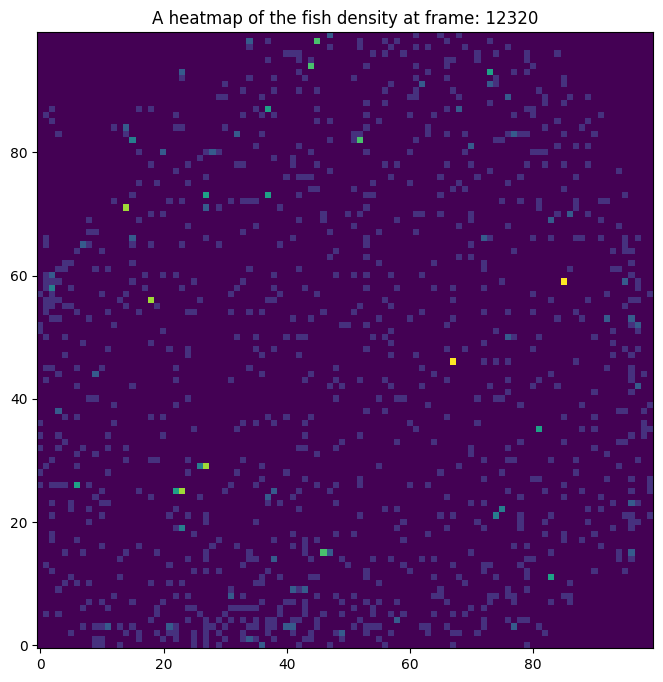

In [31]:
# It would be interesting to see a heatmap of the density of fish
# The quick and dirty way of doing this is via numpys histogram2d

# For a random time, this is the heatmap
heatmap, xedges, yedges = np.histogram2d(df.query(f'frame == {testframe}')['x'], df.query(f'frame == {testframe}')['y'], bins=100)

plt.figure(figsize=(8,8))

plt.imshow(heatmap.T, origin='lower')
plt.title('A heatmap of the fish density at frame: ' + str(testframe))
plt.show()

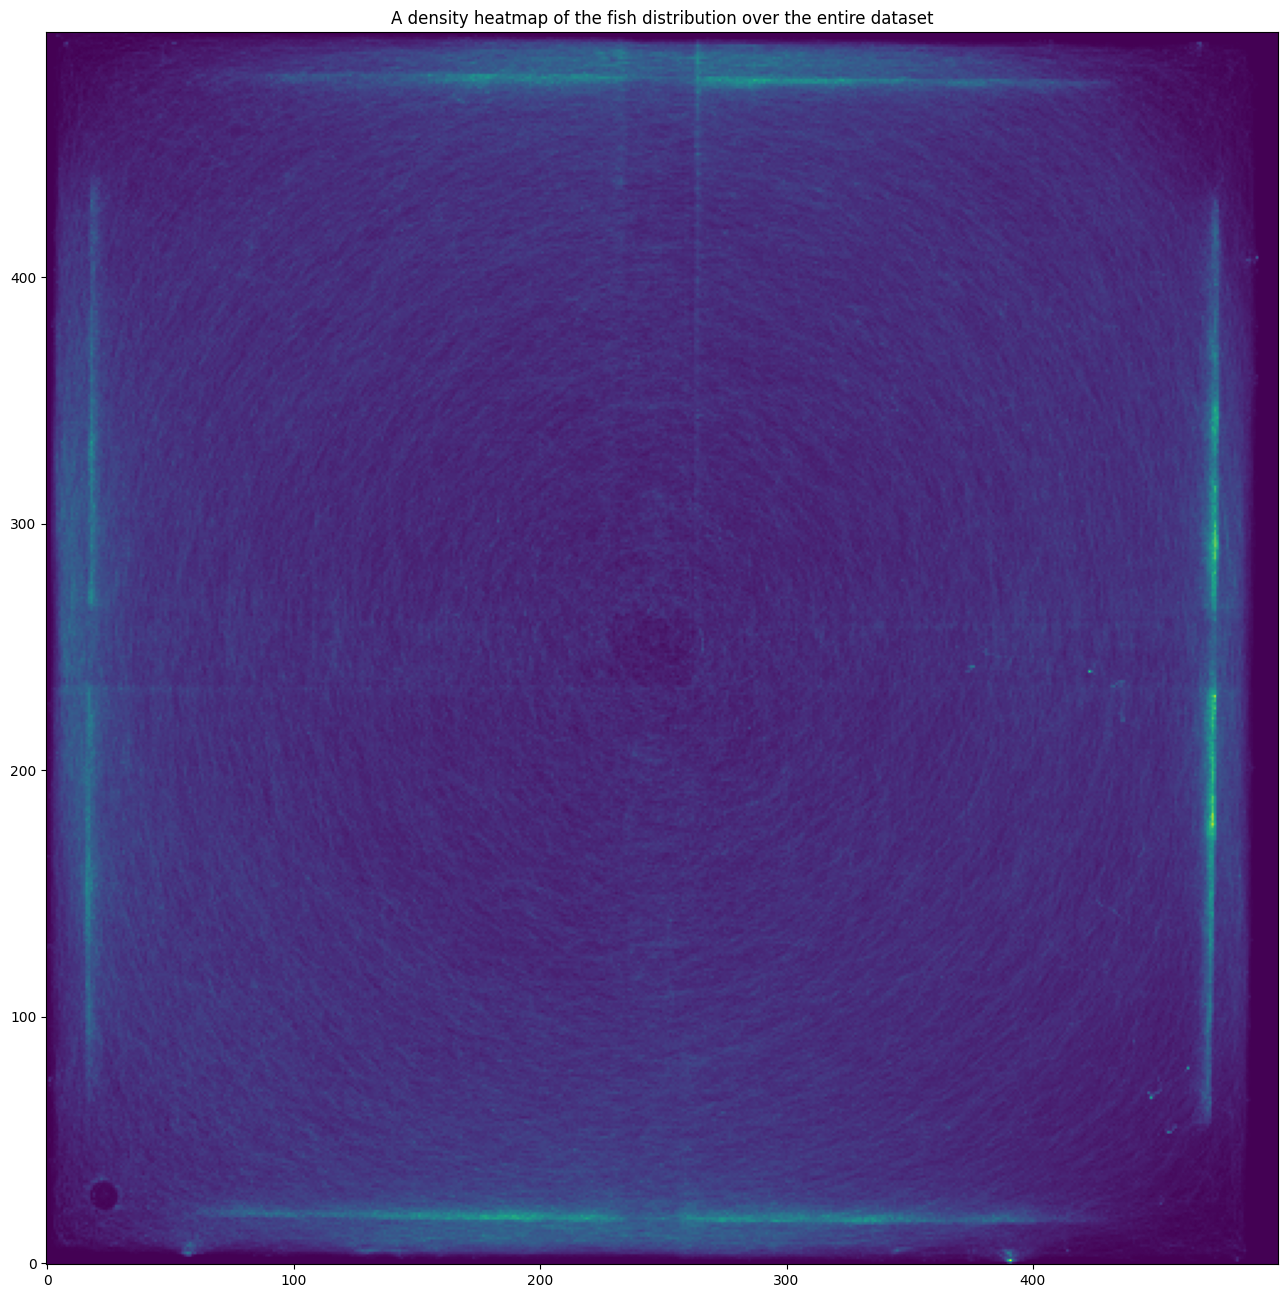

In [33]:
# We can also do this for all x and y values in a given timeframe, and in particular, for the entire dataset

heatmap, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=500)
plt.figure(figsize=(16,16))

plt.title('A density heatmap of the fish distribution over the entire dataset')
plt.imshow(heatmap.T, origin='lower')
plt.savefig('Heatmap.png')
plt.show()

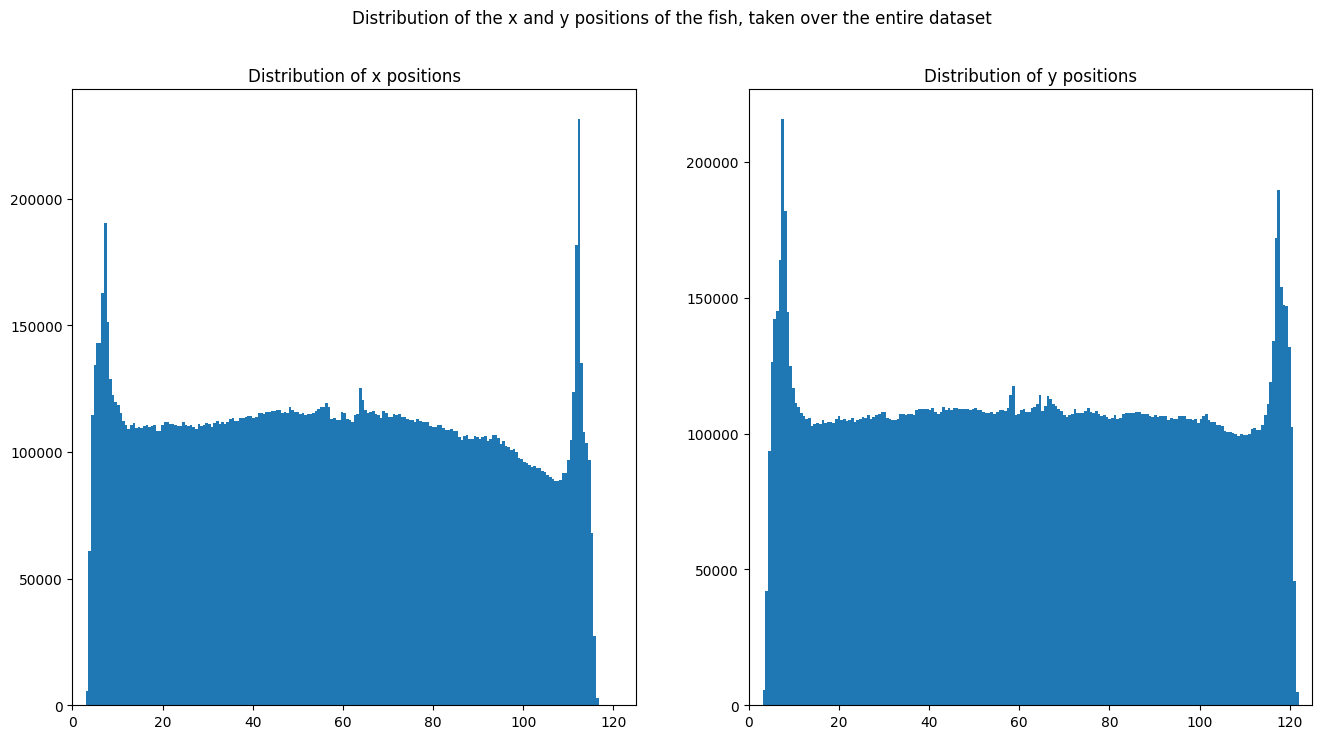

In [34]:
# In the previous image we saw some interesting things!
# Averaged over the whole time, the fish tend to congregate around the outside of the tank
# We can see this clearly in the distributions of the x and y positions

fig, ax = plt.subplots(1,2)

ax[0].hist(df['x'], bins=200)
ax[1].hist(df['y'], bins=200)

ax[0].set_xlim((xmin, xmax))
ax[1].set_xlim((ymin, ymax))

ax[0].set_title('Distribution of x positions')
ax[1].set_title('Distribution of y positions')

fig.suptitle('Distribution of the x and y positions of the fish, taken over the entire dataset')

fig.set_size_inches(16,8)

plt.show()

In [26]:
# We can also see the artifacts of the video stitching in the centre of the arena. We will need to keep both of these in mind during our later analysis. 

A smoother way to see the fish density is the use a Kernel Density Estimation. Note that the choice of bandwidth for the KDE affects the result more than the actual distribution chosen. We will use a Gaussian distribution, together with Scott's rule:
$$ bandwidth = n^ {-{1} /{d+4} }$$
where $n$ is the number of data points and $d$ is the number of dimensions.


In [35]:
def generate_kde(fr, BW = None, showfish=False):
    ''' Generates a KDE from the fish positions at some frame fr using a Gaussian Kernel, and saves it. 
    '''
    
    datax = np.array(df.query(f'frame == {fr}')['x'])
    datay = np.array(df.query(f'frame == {fr}')['y'])
    values = np.vstack((datax, datay))
    
    kernel = stats.gaussian_kde(values, bw_method=BW)
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots()

    ax.imshow(np.rot90(Z), cmap = sns.color_palette("coolwarm", as_cmap=True),
              extent=[xmin, xmax, ymin, ymax])


    ax.set_title(str("All fish at frame: " + str(fr)))
    plt.axis('off')
    fig.set_size_inches(6,6)
    
    if showfish==True:
        ax2 = ax.twinx()
        ax2.scatter(df.query(f'frame == {fr}')['x'], df.query(f'frame == {fr}')['y'], s=10, c='black')    
        ax2.set_xlim((xmin, xmax))
        ax2.set_ylim((ymin, ymax)) 
        ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False, labelright=False)

    plt.savefig(f"imgs/frame{fr}.png")
    plt.close('all')
    return kernel, fig, ax


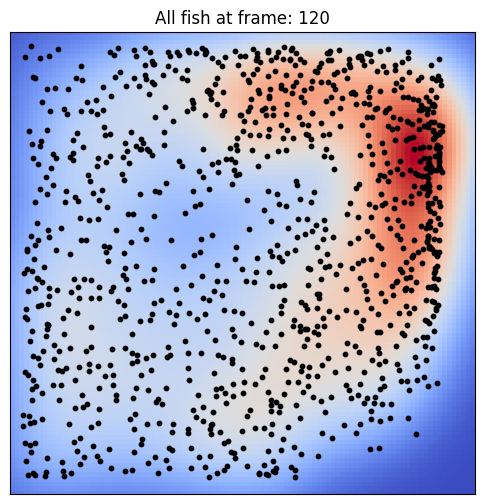

In [66]:
kernel, fig, ax = generate_kde(120, showfish=True)
fig

In [47]:
df.head()

,t,x,y,frame,vx,vy,speed
Fish,,,,,,,
0,0.225,72.011,119.372,8,0.188,-0.009,0.188
0,0.250,72.199,119.363,9,0.188,-0.009,0.188
0,0.275,72.386,119.354,10,0.225,-0.018,0.226
0,0.300,72.612,119.336,11,0.240,-0.060,0.248
0,0.325,72.852,119.275,12,0.185,-0.079,0.201


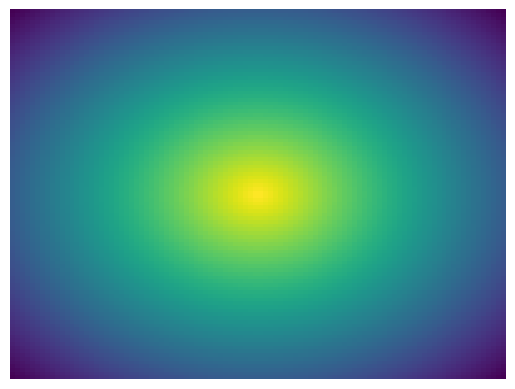

In [85]:

x,y = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))

z = (-x**2 - y**2)/np.sqrt(x**2 + y**2)


plt.axis('off')
fig.set_size_inches(6,6)

plt.pcolormesh(x, y, z) 

plt.savefig("imgs/density.png")
plt.show()

In [29]:
def generate_ind_kde(fish, BW = None, showfish=False):
    ''' Generates a KDE from the fish positions at some frame t using a Gaussian Kernel.
    '''
    
    datax = np.array(df.query(f'Fish == {fish}')['x'])
    datay = np.array(df.query(f'Fish == {fish}')['y'])
    values = np.vstack((datax, datay))
    
    kernel = stats.gaussian_kde(values, bw_method=BW)
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots()

    ax.imshow(np.rot90(Z), cmap = sns.color_palette("coolwarm", as_cmap=True),
              extent=[xmin, xmax, ymin, ymax])


    ax.set_title(str("Fish Number: " + str(fish)))
    plt.axis('off')
    fig.set_size_inches(6,6)
    
    if showfish==True:
        ax2 = ax.twinx()
        ax2.scatter(df.query(f'Fish == {fish}')['x'], df.query(f'Fish == {fish}')['y'], s=1, alpha=0.1, c='black')    
        ax2.set_xlim((xmin, xmax))
        ax2.set_ylim((ymin, ymax)) 
        ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False, labelright=False)

    plt.savefig(f"imgs/fish{fish}.png")
    plt.close('all')
    
    return kernel, fig, ax


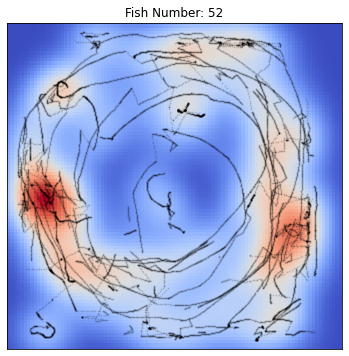

In [30]:
kernel, fig, ax = generate_ind_kde(52, showfish=True)
fig

In [31]:
df['density'] = np.nan

C:\Users\Mark\AppData\Local\Temp\ipykernel_1548\3992564395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['density'] = np.nan


In [32]:
df

,t,x,y,frame,vx,vy,speed,density
Fish,,,,,,,,
0,0.225,72.011,119.372,8,0.188,-0.009,0.188,NaN
0,0.250,72.199,119.363,9,0.188,-0.009,0.188,NaN
0,0.275,72.386,119.354,10,0.225,-0.018,0.226,NaN
0,0.300,72.612,119.336,11,0.240,-0.060,0.248,NaN
0,0.325,72.852,119.275,12,0.185,-0.079,0.201,NaN
...,...,...,...,...,...,...,...,...
1125,499.799,74.756,117.845,20008,-0.142,-0.018,0.143,NaN
1125,499.824,74.614,117.828,20009,-0.171,-0.011,0.171,NaN
1125,499.849,74.443,117.817,20010,-0.198,-0.014,0.198,NaN


We will now create a function which takes a single frame, creates the KDE for that frame, and then applies it to all the xy position of the fish in that frame. Then for each fish in the frame, we will end up with a value for the density at the xy position for the fish. We can then add this data to our original dataframe.

In [33]:
def find_frame_densities(fr):

    kernel, fig, ax = generate_kde(fr)    
    
    xpos = np.array(df.query(f'frame == {fr}')['x'])    # Store the x positions of the fish in this frame under xpos
    ypos = np.array(df.query(f'frame == {fr}')['y'])    # Store the y positions of the fish in this frame under ypos
 
    
    positions = np.vstack([xpos.ravel(), ypos.ravel()])    # Package the x and y positions together so that we can apply the KDE to them
    
    Z = np.reshape(kernel(positions).T, xpos.shape)    # Apply the KDE to the positions of the fish, and then reshape the resulting array.



    

    Zdict = dict(zip(xpos, Z))
    
    return Zdict
    

    
    
    

    
   

In [34]:
 df.query('frame == 201')

,t,x,y,frame,vx,vy,speed,density
Fish,,,,,,,,
0,5.045,101.760,101.704,201,-0.027,-0.006,0.028,NaN
1,5.045,110.129,103.202,201,0.031,-0.152,0.156,NaN
2,5.045,8.198,40.752,201,0.037,-0.103,0.110,NaN
3,5.045,43.083,42.150,201,-0.165,-0.026,0.167,NaN
4,5.045,69.821,73.566,201,-0.018,-0.029,0.034,NaN
...,...,...,...,...,...,...,...,...
1121,5.045,99.704,119.119,201,0.157,0.007,0.157,NaN
1122,5.045,113.184,83.449,201,-0.230,0.161,0.281,NaN
1123,5.045,109.776,107.435,201,0.039,-0.163,0.168,NaN


In [35]:
%%time 

Zdict = find_frame_densities(201)
selection = df['frame'] == 201
df.loc[selection, 'density'] = df.loc[selection, 'x'].map(Zdict)

CPU times: total: 703 ms
Wall time: 485 ms


In [36]:
df.query('frame == 201')

,t,x,y,frame,vx,vy,speed,density
Fish,,,,,,,,
0,5.045,101.760,101.704,201,-0.027,-0.006,0.028,0.000
1,5.045,110.129,103.202,201,0.031,-0.152,0.156,0.000
2,5.045,8.198,40.752,201,0.037,-0.103,0.110,0.000
3,5.045,43.083,42.150,201,-0.165,-0.026,0.167,0.000
4,5.045,69.821,73.566,201,-0.018,-0.029,0.034,0.000
...,...,...,...,...,...,...,...,...
1121,5.045,99.704,119.119,201,0.157,0.007,0.157,0.000
1122,5.045,113.184,83.449,201,-0.230,0.161,0.281,0.000
1123,5.045,109.776,107.435,201,0.039,-0.163,0.168,0.000


## This next cell takes about 4 hours. It computes, for each frame, the KDE for that frame. It then applies that KDE to the xy positions of the fish in the frame, and stores the resultant value in the density column. 

In [37]:
%%time 

for i in tqdm(range(df['frame'].max())):

    Zdict = find_frame_densities(i)
    selection = df['frame'] == i
    df.loc[selection, 'density'] = df.loc[selection, 'x'].map(Zdict)

  0%|          | 0/20012 [00:00<?, ?it/s]

CPU times: total: 4h 20min 55s
Wall time: 2h 45min 24s


In [46]:
df.isna().sum()

t            0
x            0
y            0
frame        0
vx           0
vy           0
speed        0
density    865
dtype: int64

In [47]:
# Once again we will drop these na values
df = df.dropna()

In [48]:
# Finally, let us save the DataFrame to a csv file so we can use it later
df.to_csv('1024sunbleak_clean.csv')

In [38]:
def generate_kde_3d(BW = None, showfish=False):
    ''' Generates a KDE from the fish positions at all times using a Gaussian Kernel, and saves it. 
    '''
    
    datax = np.array(df['x'])
    datay = np.array(df['y'])
    datat = np.array(df['t'])
    values = np.vstack((datax, datay, datat))
    
    kernel = stats.gaussian_kde(values, bw_method=BW)
    return kernel

In [39]:
# %%time

#X, Y = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]
#T = np.array([100 for i in range(10*10)])
#positions = np.vstack((X.ravel(), Y.ravel(), T.ravel()))
#Z = np.reshape(kernel(positions).T, X.shape)

#fig, ax = plt.subplots()

#ax.imshow(np.rot90(Z), cmap = sns.color_palette("coolwarm", as_cmap=True),
#          extent=[xmin, xmax, ymin, ymax])

In [40]:
#kernel, fig, ax = generate_kde(100, showfish=True)
#fig

In [41]:
# Finally, let us save the DataFrame to a csv file so we can use it later
#df.to_csv('1024sunbleak_clean.csv')

In [42]:
#%%time


#filepaths
#filenames = [f"imgs/frame{5*i}.png" for i in range(100,200)]
#fp_out = "imgs/movie.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
#imgs = (Image.open(f) for f in filenames)
#img = next(imgs)  # extract first image from iterator
#img.save(fp=fp_out, format='GIF', append_images=imgs,
#save_all=True, duration=25, loop=0)

IndentationError: unexpected indent (1340945645.py, line 12)